# *Lending Club Loan Default*

In this tutorial, we will go through a step-by-step workflow to determine loan deliquency. Predictions will be made based only on the information available at the time the loan was issued.  Our data is a portion of the public Lending Club data set.

## Workflow

1. Start H2O-3 cluster
2. Import data
3. Clean data
4. Feature engineering
5. Model training
6. Examine model accuracy
7. Interpret model
8. Save and reuse model
9. AutoML (optional)
10. Stop H2O-3 cluster

# Step 1 (of 10). Start H2O-3 cluster

The method you use for starting and stopping an H2O-3 cluster will depend on how H2O is set up on your system. The method we show here is the simplest and most straightforward. It is critical, however, that you properly shut down any H2O cluster that you start.

In [19]:
import h2o
h2o.init(bind_to_localhost=False)  # run and expose the cluster to the Internet

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 hours 21 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,"21 days, 19 hours and 29 minutes"
H2O cluster name:,H2O_from_python_dwhiting_ytmqne
H2O cluster total nodes:,1
H2O cluster free memory:,3.805 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


# Step 2 (of 10). Import data

A full description of the complete Lending Club data is available at kaggle.com [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook). 

The data set we use below is a local copy of https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/lending/lending_club/LoanStats3a.csv.

### View and Inspect the Data

The loans data is loaded directly into H2O using the following command:

In [20]:
loans = h2o.import_file("../../data/lending_club/LoanStats3a.csv",
                        col_types = {"int_rate":"string", 
                                     "revol_util":"string", 
                                     "emp_length":"string", 
                                     "verification_status":"string"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


Note that the `h2o.import_file` command completely bypassed python and loaded the data directly into H2O memory. Alternatively, one could load a dataset into a python object, for instance, then pass it to H2O. The approach we use above is far more efficient and generally recommended, especially as data size increases.

### Inspect the Data with H2O Flow

Now is a good time to enable H2O Flow. Although H2O Flow can be used for everything from loading data to building models to creating production code, we use it here for data investigation and H2O system monitoring.

> Note: the reported IP above 
>
>```
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
>```
>
> is the local IP within your particular cloud instance. 
>
> **To open H2O Flow in your own browser, copy your browser URL and replace the port with 54321.**
>
>> For example, my Jupyter notebook's URL is 
>>
>>`http://52.202.98.125:8888`. 
>>
>> After opening a new browser tab or window, I copy the address and replace port `8888` with `54321`:
>>
>>`http://52.202.98.125:54321`.

A quick summary of the data size and data fields are shown below.

In [21]:
loans.dim

[42536, 52]

In [22]:
loans.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1.0775e+06,1.2966e+06,5000,5000,4975,36 months,10.65%,162.87,B,B2,,10+ years,RENT,24000,VERIFIED - income,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.,credit_card,Computer,860xx,AZ,27.65,0,1985-01-01 00:00:00,1,,,3,0,13648,83.7%,9,f,0,0,5861.07,5831.78,5000,861.07,0,0,0,2015-01-01 00:00:00,171.62,,2015-01-01 00:00:00,0,,1
1.07743e+06,1.31417e+06,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000,VERIFIED - income source,2011-12-01 00:00:00,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces,car,bike,309xx,GA,1,0,1999-04-01 00:00:00,5,,,3,0,1687,9.4%,4,f,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,2013-04-01 00:00:00,119.66,,2013-09-01 00:00:00,0,,1
1.07718e+06,1.31352e+06,2400,2400,2400,36 months,15.96%,84.33,C,C5,,10+ years,RENT,12252,not verified,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,,small_business,real estate business,606xx,IL,8.72,0,2001-11-01 00:00:00,2,,,2,0,2956,98.5%,10,f,0,0,3003.65,3003.65,2400,603.65,0,0,0,2014-06-01 00:00:00,649.91,,2015-06-01 00:00:00,0,,1
1.07686e+06,1.27718e+06,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.",other,personel,917xx,CA,20,0,1996-02-01 00:00:00,1,35,,10,0,5598,21%,37,f,0,0,12226.3,12226.3,10000,2209.33,16.97,0,0,2015-01-01 00:00:00,357.48,,2015-01-01 00:00:00,0,,1
1.07536e+06,1.31175e+06,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000,VERIFIED - income source,2011-12-01 00:00:00,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay toward other bills. I've always been a good payor but have found myself needing to make adjustments to my budget due to a medical scare. My job is very stable, I love it.",other,Personal,972xx,OR,17.94,0,1996-01-01 00:00:00,0,38,,15,0,27783,53.9%,38,f,1168.04,1168.04,2767.64,2767.64,1831.96,935.68,0,0,0,2015-06-01 00:00:00,67.79,2015-07-01 00:00:00,2015-06-01 00:00:00,0,,1
1.07527e+06,1.31144e+06,5000,5000,5000,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanD

------

>## Editorial comment: Data preparation for modeling
>
>In this tutorial, we either omit or rush through some steps that a modeler normally would spend a considerable amount of time on. For example, we completely skip exploratory data analysis used in conjunction with modeling. Additionally, the process of **defining the problem** is often iterative and takes a lot of thought and effort. 
>
>In reality, the majority of a modeler's time is spent on problem definition and data cleaning/wrangling/munging. Our speed at going through these steps to demonstrate the use of H2O-3 in no way minimizes the importance of careful and thoughtful data preparation for model building.

-----


# Step 3 (of 10).  Clean data


## Part 1. Defining the problem and creating the response variable

The total number of loans in our data is

In [23]:
num_unfiltered_loans = loans.dim[0]
num_unfiltered_loans

42536

Because we are interested in loan default, we need to look at the `loan_status` column.

In [24]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


Like many real data sources, `loan_status` is messy and contains multiple (somewhat overlapping) categories. Before modeling, we will need to clean this up by (1) removing loans that are still ongoing, and (2) simplifying the response column.

### (1) Filter Loans

In order to build a valid model, we have to remove loans that are not yet completely "good" or "bad". These ongoing loans have `loan_status` like "Current" and "In Grace Period".

In [25]:
ongoing_status = ["Current",
                  "In Grace Period",
                  "Late (16-30 days)",
                  "Late (31-120 days)",
                  "Does not meet the credit policy.  Status:Current",
                  "Does not meet the credit policy.  Status:In Grace Period"
                 ]
loans = loans[~loans["loan_status"].isin(ongoing_status)]

After filtering out ongoing loans, we now have

In [26]:
num_filtered_loans = loans.dim[0]
num_filtered_loans

38980

loans whose final state is known, which means we filtered out

In [27]:
num_loans_filtered_out = num_unfiltered_loans - num_filtered_loans
num_loans_filtered_out

3556

loans. 

These loans are now summarized by `loan_status` as

In [28]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1933
Fully Paid,30843


### (2) Create Response Column

Let's name our response column `bad_loan`, which will be equal to one if the loan was not completely paid off.

In [29]:
fully_paid = ["Fully Paid",
              "Does not meet the credit policy.  Status:Fully Paid"
             ]
loans["bad_loan"] = ~(loans["loan_status"].isin(fully_paid))

Make the `bad_loan` column a factor so we can build a classification model,

In [30]:
loans["bad_loan"] = loans["bad_loan"].asfactor()

The percentage of bad loans is given by

In [31]:
bad_loan_dist = loans["bad_loan"].table()
bad_loan_dist["Percentage"] = (100 * bad_loan_dist["Count"] / loans.nrow).round()
bad_loan_dist

bad_loan,Count,Percentage
0,32776,84
1,6204,16


## Part 2. Convert strings to numeric

Consider the data columns `int_rate`, `revol_util`, and `emp_length`:

In [32]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65%,83.7%,10+ years
15.27%,9.4%,< 1 year
15.96%,98.5%,10+ years
13.49%,21%,10+ years
7.90%,28.3%,3 years
18.64%,87.5%,9 years
21.28%,32.6%,4 years
12.69%,36.5%,< 1 year
14.65%,20.6%,5 years
12.69%,67.1%,10+ years


Both `int_rate` and `revol_util` are inherently numeric but entered as percentages. Since they include a "%" sign, they are read in as strings. The solution for both of these columns is simple: strip the "%" sign and convert the strings to numeric.

The `emp_length` column is only slightly more complex. Besides removing the "year" or "years" word, we have to deal with `< 1` and `10+`, which aren't directly numeric. If we define `< 1` as 0 and `10+` as 10, then `emp_length` can also be cast as numeric.

We demonstrate the steps for converting these string variables into numeric values below.

### Convert `int_rate`

In [33]:
loans["int_rate"] = loans["int_rate"].gsub(pattern = "%", replacement = "") # strip %
loans["int_rate"] = loans["int_rate"].trim() # trim whitespace
loans["int_rate"] = loans["int_rate"].asnumeric() # change to numeric 

### Convert `revol_util`

In [35]:
loans["revol_util"] = loans["revol_util"].gsub(pattern="%", replacement="") # strip %
loans["revol_util"] = loans["revol_util"].trim() # trim whitespace
loans["revol_util"] = loans["revol_util"].asnumeric() # change to numeric 

### Convert `emp_length`

In [36]:
# Use gsub to remove " year" and " years"; also translate n/a to "" 
loans["emp_length"] = loans["emp_length"].gsub(pattern="([ ]*+[a-zA-Z].*)|(n/a)", replacement="") 
loans["emp_length"] = loans["emp_length"].trim() # trim whitespace

loans["emp_length"] = loans["emp_length"].gsub(pattern="< 1", replacement="0") # convert "< 1" to 0
loans["emp_length"] = loans["emp_length"].gsub(pattern="10\\+", replacement="10") # convert "10+" to 10
loans["emp_length"] = loans["emp_length"].asnumeric() # trim whitespace

The converted results for the three former string variables are

In [37]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65,83.7,10
15.27,9.4,0
15.96,98.5,10
13.49,21,10
7.9,28.3,3
18.64,87.5,9
21.28,32.6,4
12.69,36.5,0
14.65,20.6,5
12.69,67.1,10


### Note: Interest rate distributions

Now that we have converted interest rate to numeric, we can use the `hist` function to compare the interest rate distributions for good and bad loans.

Bad Loans


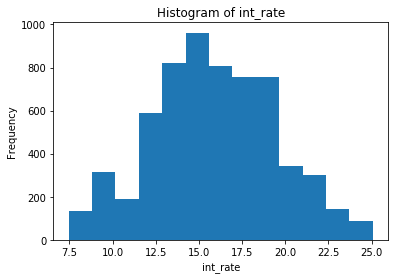

Good Loans


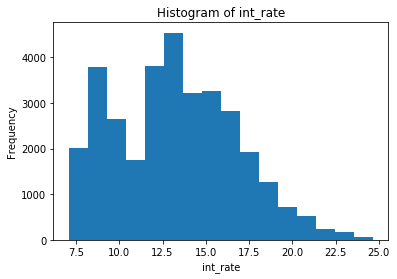

In [41]:
%matplotlib inline

print("Bad Loans")
loans[loans["bad_loan"] == "1", "int_rate"].hist()

print("Good Loans")
loans[loans["bad_loan"] == "0", "int_rate"].hist()

As expected, the bad loan distribution contains a higher proportion of high interest rates than the distribution for good loans. Likewise, the good loan distribution contains a higher proportion of low interest rates than that for bad loans. It is a truism to say that interest rate should be a good predictor of default.

>Financial institutions typically determine a loan's interest rate based largely on risk and customer demand. If the underwriting rules are any good at all, then we would expect that interest rate would be a strong predictor of default. In fact, we should be surprised if `int_rate` is not one of the top two or three variables in our model regardless of algorithm.

## Part 3. Clean up messy categorical columns

Much as we did with the `loan_status` column to create our response variable, the `verification_status` column needs cleaning

In [65]:
loans["verification_status"].head()

verification_status
verified
verified
not verified
verified
verified
verified
verified
verified
not verified
verified


Note that there are multiple values that mean verified: `VERIFIED - income` and `VERIFIED - income source`.  We will replace these values with `verified`,

In [66]:
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income source", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].asfactor()

resulting in

In [67]:
loans["verification_status"].table()

verification_status,Count
not verified,17947
verified,21032


# ^^^^^ --DONE TO HERE-- ^^^^^

# Step 4 (of 10).  Feature engineering

Now that we have cleaned our data, we can add some new columns to our dataset that may help improve the performance of our supervised learning models.

The new columns we will create are: 
* `credit_length`: the time from their earliest credit line to when they were issued the loan
* `issue_d_year` and `issue_d_month`: extract year and month from the issue date
* word embeddings from the loan description

### Credit Length

We can extract the credit length by subtracting the year they had their earliest credit line from the year when they issued the loan.

In [45]:
loans["credit_length"] = loans["issue_d"].year() - loans["earliest_cr_line"].year()
loans["credit_length"].head()

credit_length
26
12
10
15
7
4
7
7
13
22


### Issue Date Expansion

We can extract the year and month from the issue date.  We may find that the month or the year when the loan was issued can impact the probability of a bad loan.

In [46]:
loans["issue_d_year"] = loans["issue_d"].year()
loans["issue_d_month"] = loans["issue_d"].month().asfactor()  # we will treat month as a enum/factor since its cyclical

In [47]:
loans[["issue_d_year", "issue_d_month"]].head()

issue_d_year,issue_d_month
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12


### Word Embeddings

One of the columns in our dataset is a description of why the loan was requested. The first few descriptions in the dataset are shown below.

In [48]:
loans["desc"].head()

desc
Borrower added on 12/22/11 > I need to upgrade my business technologies.
Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces
""
"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time."
""
Borrower added on 12/16/11 > Downpayment for a car.
Borrower added on 12/21/11 > I own a small home-based judgment collection business. I have 5 years experience collecting debts. I am now going from a home office to a small office. I also plan to buy a small debt portfolio (eg. $10K for $1M of debt) My score is not A+ because I own my home and have no mortgage.
"Borrower added on 12/16/11 > I'm trying to build up my credit history. I live with my brother and have no car payment or credit cards. I am in community college and work full time. Im going to use the money to make some repairs around the house and get some maintenance done on my car. Borrower added on 12/20/11 > $1000 down only $4375 to go. Thanks to everyone that invested so far, looking forward to surprising my brother with the fixes around the house."
"Borrower added on 12/15/11 > I had recived a loan from Citi Financial about a year ago, I was paying 29.99 intrest, so the refinance is to cut that rate since cleaning up my credit I have been paying everything on time as shown on my credit report"
""


This information may be important to the model but supervised learning algorithms have a hard time understanding text.  Instead we will convert these strings to a numeric vector using the Word2Vec algorithm.

In [49]:
STOP_WORDS = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what",
              "there","all","we","one","the","a","an","of","or","in","for","by","on",
              "but","is","in","a","not","with","as","was","if","they","are","this","and","it","have",
              "from","at","my","be","by","not","that","to","from","com","org","like","likes","so"]

In [50]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [51]:
# Break loan description into sequence of words
words = tokenize(loans["desc"].ascharacter())

In [52]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size=100, model_id="w2v")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [53]:
# Sanity check - find synonyms for the word 'car'
w2v_model.find_synonyms("car", count=5)

OrderedDict([('auto', 0.763145387172699),
             ('vehicle', 0.7259807586669922),
             ('camry', 0.7110589146614075),
             ('prius', 0.6838164329528809),
             ('lexus', 0.6703235507011414)])

In [54]:
# Calculate a vector for each description
desc_vecs = w2v_model.transform(words, aggregate_method="AVERAGE")

In [55]:
desc_vecs.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.197705,0.0846501,0.0253813,0.0387419,0.0172716,0.00308003,-0.0490285,0.22468,0.0101228,0.111312,0.0367925,0.284432,-0.0501633,0.126303,-0.0337303,-0.113763,-0.0323753,0.14291,0.0170148,0.0691567,-0.127635,-0.0322579,0.161731,-0.262116,0.0724791,-0.141735,0.0491878,0.0534475,-0.00766658,0.0801733,0.0167333,0.122463,-0.00263546,0.0946333,-0.0407148,-0.0249624,-0.250554,-0.0650692,0.157923,0.175268,0.105844,-0.0454766,-0.14973,0.245281,-0.0601556,-0.0411163,0.0503671,0.034353,-0.147848,-0.145278,-0.13047,0.0535316,0.00824645,-0.101392,0.234308,0.0241247,-0.217863,0.0662003,-0.247796,0.00970436,-0.10506,0.137001,-0.142647,-0.133504,0.0346545,0.0305247,0.0652317,-0.0756486,0.0375317,0.0206133,-0.0111574,-0.0884336,0.239316,-0.203146,0.240564,0.111173,-0.028851,0.108163,-0.0129985,0.0178561,0.0514973,-0.104319,-0.0818921,0.269724,0.0174731,-0.178767,0.0897161,0.238923,0.0241475,-0.097289,0.0941949,0.0515817,0.121173,-0.0645276,0.107661,-0.199429,-0.154932,0.0216121,0.131998,0.0864836
0.164136,0.0405533,-0.0478219,-0.0944358,0.00969207,-0.245943,-0.0137975,0.157752,0.0663062,0.0632403,0.0924674,0.144431,-0.0325053,-0.0412965,0.0614722,0.0030058,0.0471577,0.155596,0.0311329,-0.0262627,-0.0779998,-0.0176146,0.0961411,-0.149455,-0.0408993,-0.0665188,0.0298287,0.0433703,0.0242192,-0.00494156,-0.0710944,0.189741,0.013757,0.115975,-0.0177112,0.137039,-0.161043,-0.195475,0.0149978,0.107624,0.123133,-0.0362716,-0.122495,0.0158226,-0.0814765,0.0377797,0.0540302,-0.0494509,-0.103196,-0.134098,-0.0212903,0.0572451,-0.087192,-0.0960699,0.196988,-0.0149758,-0.19031,0.0674576,-0.175004,0.038295,0.005699,0.0244796,-0.0549679,-0.121808,0.0502136,-0.0401679,0.00548383,0.0295925,0.0474973,0.0612107,0.000383874,-0.0731379,0.186402,-0.134827,0.19089,0.149568,-0.083482,0.147129,-0.0758558,-0.120242,0.153063,-0.148508,-0.00390821,0.363978,0.202469,-0.165774,-0.0736031,0.138887,-0.076485,-0.161318,-0.0328524,-0.0813271,0.0722321,-0.0188082,0.105771,-0.147258,-0.0850242,0.0269507,-0.0142734,-0.021255
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.110682,-0.00520883,-0.0317378,-0.13169,0.0174637,-0.0737664,0.0763666,0.227136,0.102623,0.074469,0.0483868,0.100159,-0.0623702,0.0266576,0.0549758,0.00393723,0.0136486,0.20984,-0.0485859,-0.0383691,-0.0251006,-0.0628735,0.120821,-0.155655,-0.0460407,-0.0433538,0.0185734,0.0507029,0.0133222,-0.0322679,-0.015278,0.172422,0.00870004,0.186655,-0.0936924,0.149563,-0.228144,-0.13135,0.00793222,0.0972787,-0.0226066,-0.0619765,-0.0856864,0.0357287,-0.134563,0.0788604,0.0450616,0.00682109,-0.105484,-0.0962532,-0.195282,0.00396452,-0.0381191,-0.106363,0.159924,-0.0752879,-0.0505262,0.0237687,-0.188577,0.0678453,0.0688898,0.0265936,-0.167097,-0.168652,0.0337974,-0.0222777,-0.00476023,0.00799328,0.00116332,0.0610144,0.0608556,-0.186194,0.189271,-0.030142,0.22516,0.0924382,-0.156014,0.146784,-0.0480725,-0.0838403,0.151441,-0.186983,-0.0746462,0.306968,0.181513,-0.250775,0.0286643,0.250176,-0.0295081,-0.137385,-0.0692815,0.0157436,0.0745148,-0.0475676,0.0497331,-0.112032,-0.140675,-0.0150226,0.0156577,-0.0473443
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

In [56]:
# Add aggregated word embeddings 
loans = loans.cbind(desc_vecs)

# Step 5 (of 10). Model training

Now that we have cleaned our data and added new columns, we will train a model to predict bad loans.

In [57]:
train, test = loans.split_frame(seed=25, ratios=[0.75])

In [58]:
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoost

cols_to_remove = ["initial_list_status",
                  "out_prncp",
                  "out_prncp_inv",
                  "total_pymnt",
                  "total_pymnt_inv",
                  "total_rec_prncp", 
                  "total_rec_int",
                  "total_rec_late_fee",
                  "recoveries",
                  "collection_recovery_fee",
                  "last_pymnt_d", 
                  "last_pymnt_amnt",
                  "next_pymnt_d",
                  "last_credit_pull_d",
                  "collections_12_mths_ex_med" , 
                  "mths_since_last_major_derog",
                  "policy_code",
                  "loan_status",
                  "funded_amnt",
                  "funded_amnt_inv",
                  "mths_since_last_delinq",
                  "mths_since_last_record",
                  "id",
                  "member_id",
                  "desc",
                  "zip_code"]

predictors = list(set(loans.col_names) - set(cols_to_remove))

In [59]:
predictors

['int_rate',
 'C69',
 'inq_last_6mths',
 'C98',
 'grade',
 'C62',
 'C21',
 'C100',
 'C64',
 'C16',
 'C40',
 'C19',
 'C15',
 'C52',
 'C84',
 'C70',
 'earliest_cr_line',
 'C18',
 'C87',
 'C92',
 'C1',
 'total_acc',
 'C45',
 'C46',
 'C34',
 'C38',
 'verification_status',
 'C37',
 'delinq_2yrs',
 'C68',
 'C54',
 'C5',
 'C25',
 'C14',
 'C60',
 'C39',
 'bad_loan',
 'C57',
 'purpose',
 'C35',
 'C56',
 'C24',
 'C29',
 'C78',
 'C81',
 'C88',
 'C41',
 'C94',
 'C80',
 'C49',
 'C58',
 'C32',
 'C28',
 'C75',
 'C90',
 'C93',
 'C7',
 'C53',
 'C74',
 'C22',
 'url',
 'C79',
 'C6',
 'credit_length',
 'C42',
 'C23',
 'C85',
 'C77',
 'revol_util',
 'C76',
 'C95',
 'C67',
 'C51',
 'C30',
 'C31',
 'addr_state',
 'C83',
 'C26',
 'emp_title',
 'annual_inc',
 'C63',
 'C10',
 'C9',
 'term',
 'pymnt_plan',
 'dti',
 'C48',
 'C65',
 'C55',
 'issue_d_month',
 'C20',
 'C99',
 'C3',
 'loan_amnt',
 'issue_d',
 'C61',
 'C4',
 'C13',
 'C50',
 'C66',
 'C96',
 'open_acc',
 'C82',
 'installment',
 'C27',
 'C59',
 'C36',
 '

In [62]:
h2o_gbm_model = H2OGradientBoostingEstimator(stopping_metric="logloss",
                                         stopping_rounds= 5,  # early stopping
                                         score_tree_interval=5,
                                         ntrees=500,
                                         model_id="gbm",
                                         nfolds=5,
                                         seed=25,
                                         fold_assignment='stratified')
h2o_gbm_model.train(x=predictors,
                y="bad_loan",
                training_frame=train,
                validation_frame=test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Step 7 (of 10).  Examine model accuracy

The plot below shows the performance of the model as more trees are built.  This graph can help us see if our model is overfitting.  Our early stopping kicked in at 100 trees.  This is where the model was no longer improving performance on the test data.

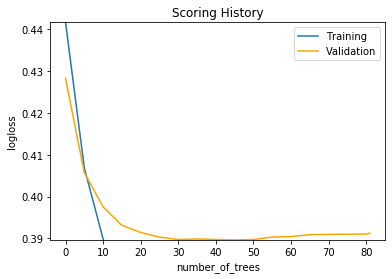

In [63]:
%matplotlib inline
h2o_gbm_model.plot()

The ROC curve of the training and testing data are shown below.  The area under the ROC curve is much higher for the training data than the testing data indicating that the model may be beginning to memorize the training data.

Training Data


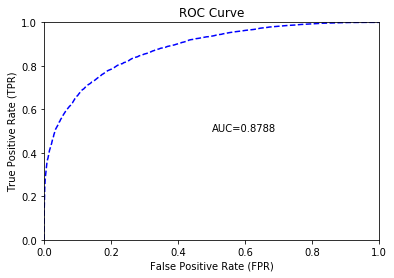

Testing Data


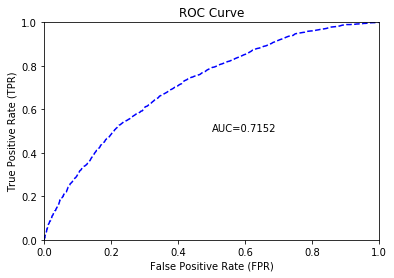

X-Val


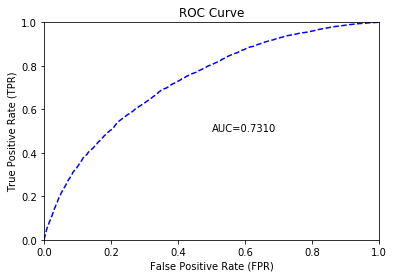

In [64]:
print("Training Data")
gbm_model.model_performance(train = True).plot()
print("Testing Data")
gbm_model.model_performance(valid = True).plot()
print("X-Val")
gbm_model.model_performance(xval=True).plot()

# Step 7 (of 10). Interpret model

The variable importance plot shows us which variables are most important to predicting `bad_loan`.  We can use partial dependency plots to learn more about how these variables affect the prediction.

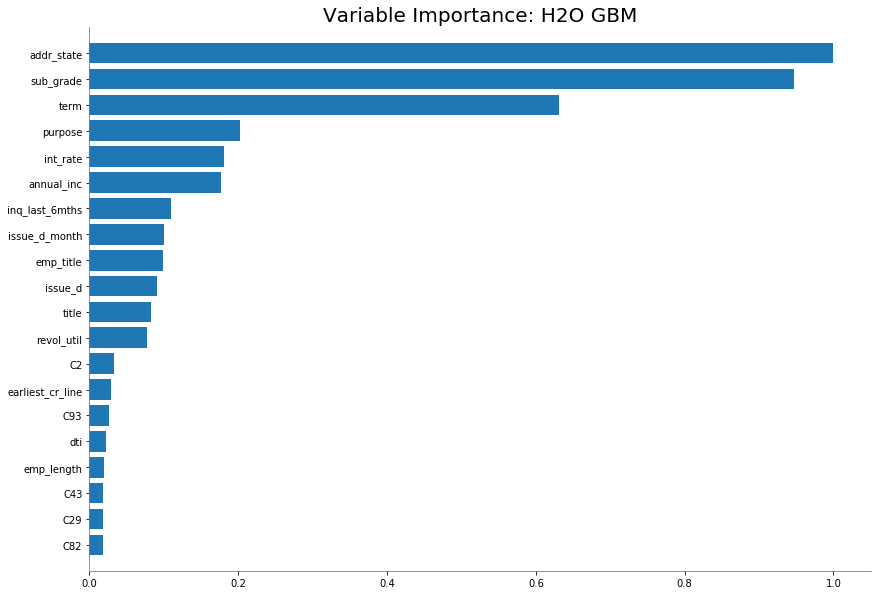

In [68]:
gbm_model.varimp_plot(20)

The partial dependency plot of the `inq_last_6mths` predictor shows us that, as the number of inquiries in the last 6 months increases, the likelihood of the loan defaulting also increases.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


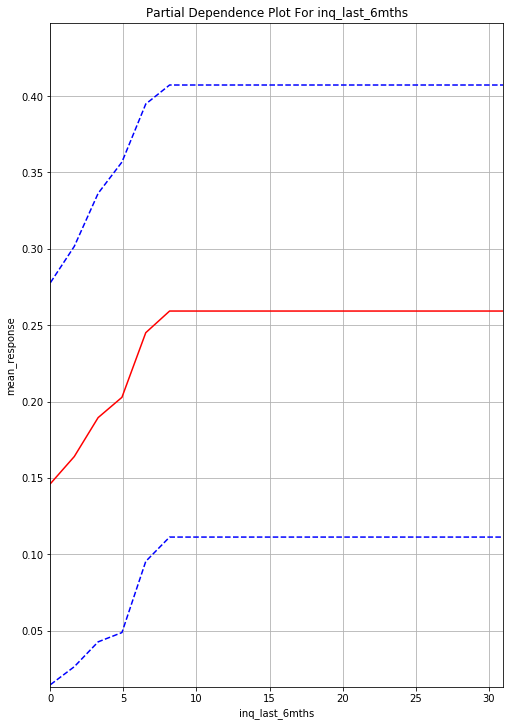

In [69]:
pdp = gbm_model.partial_plot(cols=["inq_last_6mths"], data=train)

In [70]:
loans["inq_last_6mths"].table().head(100)

inq_last_6mths,Count
0,17908
1,10287
2,5478
3,2942
4,1001
5,577
6,324
7,177
8,111
9,50


# Step 8 (of 10). Save and reuse model

The model can either be embedded into a self-contained Java MOJO/POJO package
or it can be saved and later loaded directly in H2O-3 cluster. For production
use, we recommend to use MOJO as it is optimised for speed. See the [guide](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html) for further information.

### Downloading MOJO

In [ ]:
gbm_model.download_mojo()

### Save and reuse the model 

We can save the model to disk for later batch scoring in H2O cluster.

In [ ]:
model_path = h2o.save_model(model=gbm_model, force=True)
print(model_path)
loaded_model = h2o.load_model(path=model_path)

We can also score new data using the predict function:

In [ ]:
bad_loan_hat = loaded_model.predict(test)
bad_loan_hat.head(15)

# Step 9 (of 10). AutoML (optional)
AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. Stacked Ensembles will be automatically trained on collections of individual models to produce highly predictive ensemble models.

In [71]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_runtime_secs=300, seed=25)
aml.train(x=predictors, y='bad_loan', training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


The leaderboard contains the performance metrics of the models generated by AutoML:

In [72]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190710_210457,0.73434,0.392841,0.329755,0.348424,0.121399


Since we provided only training frame during training, the models are sorted by their cross-validated performance metrics (AUROC by default for classification). We can evaluate the best model (`leader`) on the test data:

In [ ]:
aml.leader.model_performance(test_data=test).plot()
aml.leader.model_performance(test_data=test)

# Step 10 (of 10). Stop H2O-3 cluster

In [ ]:
h2o.cluster().shutdown()

# Bonus: H2O-3 documentation

* http://docs.h2o.ai